<a href="https://colab.research.google.com/github/kozoB/steam-sarcasm-detection/blob/main/Steam_Reviews_Sarcasm_Detection_Project_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam Reviews Sarcasm Detection

# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

# Load Dataset

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Read the CSV file
dataset_path = '/content/drive/MyDrive/Masters Degree/NLP Course/Steam Reviews Sarcasm Detection Project/dataset/steam_reviews_dataset_labeled.csv'
steam_reviews = pd.read_csv(dataset_path)

# Display the first few rows
steam_reviews.head()

Mounted at /content/drive


,app_id,app_name,review_text,review_score,review_votes,sarcasm_label
0,10,Counter-Strike,Ruined my life.,1,0,1
1,10,Counter-Strike,This game saved my virginity.,1,0,1
2,10,Counter-Strike,â€¢ Do you like original games? â€¢ Do you lik...,1,0,1
3,10,Counter-Strike,"Easy to learn, hard to master.",1,1,0
4,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1,1


In [4]:
print(f"steam_reviews shape:\n{steam_reviews.shape}\n")
print(f"{steam_reviews['sarcasm_label'].value_counts()}")

steam_reviews shape:
(563, 6)

sarcasm_label
0    313
1    250
Name: count, dtype: int64


# Exploratory Data Analysis (EDA) and Feature Engineering

## Label Distribution

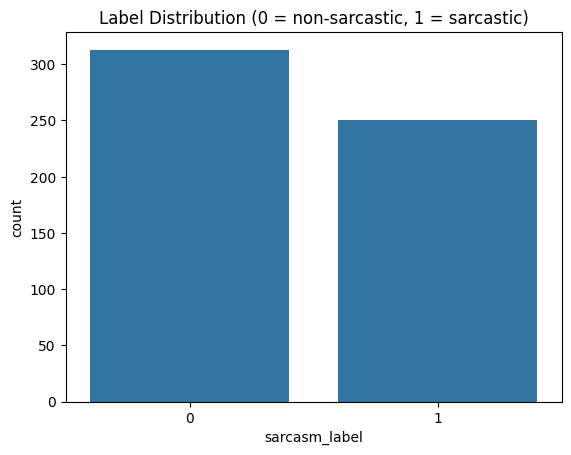

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sarcasm_label', data=steam_reviews)
plt.title("Label Distribution (0 = non-sarcastic, 1 = sarcastic)")
plt.show()

## Review Score vs. Sarcasm Correlation

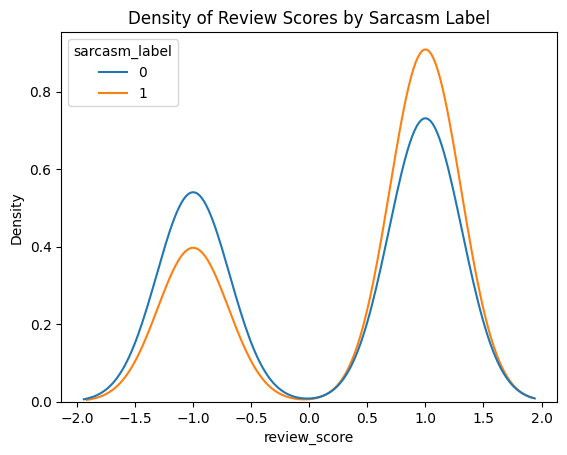

In [6]:
sns.kdeplot(data=steam_reviews, x='review_score', hue='sarcasm_label', common_norm=False)
plt.title("Density of Review Scores by Sarcasm Label")
plt.show()

This plot shows the distribution of review scores for sarcastic and non-sarcastic Steam reviews. While both classes contain a mix of positive (+1) and negative (-1) review scores, sarcastic reviews tend to be skewed more toward positive scores. This suggests that many sarcastic reviews outwardly "recommend" the game, likely using irony to express dissatisfaction - a common sarcasm pattern. In contrast, non-sarcastic reviews display a more balanced distribution between negative and positive scores. This highlights a key challenge in sarcasm detection: sarcastic comments may appear positive in rating but convey negative sentiment in text. As a result, the review_score feature may be misleading on its own, but when combined with text, it becomes a valuable signal for distinguishing genuine praise from sarcasm.

## Density of Review Votes By Srcasm Label

In [ ]:
sns.kdeplot(data=steam_reviews, x='review_votes', hue='sarcasm_label', common_norm=False)
plt.title("Density of Review Votes by Sarcasm Label")
plt.show()

The distribution of 'review_votes' reveals that both sarcastic and non-sarcastic reviews typically receive few or no votes, with a sharp peak near zero.
However, sarcastic reviews show a slightly higher density at the upper end, suggesting that sarcastic content may be more engaging or memorable, making it more likely to be voted as helpful by other users. While this feature alone may not be strongly discriminative, it could still carry subtle signal when combined with textual features in a multimodal sarcasm detection model. Therefore, 'review_votes' is retained as a metadata feature during training.

## Density of Sentiment By Sarcasm Label

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


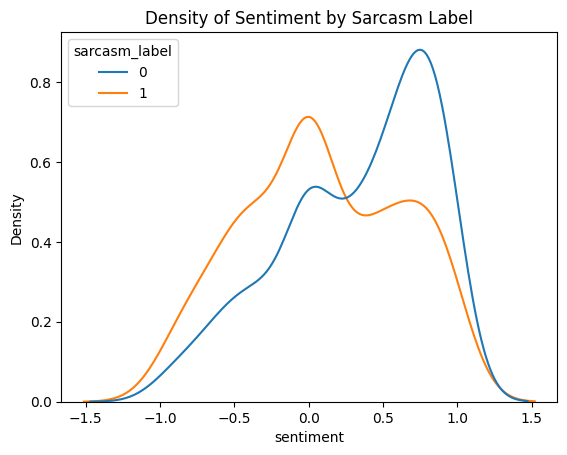

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

steam_reviews['sentiment'] = steam_reviews['review_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

sns.kdeplot(data=steam_reviews, x='sentiment', hue='sarcasm_label', common_norm=False)
plt.title("Density of Sentiment by Sarcasm Label")
plt.show()

Sentiment analysis using VADER reveals that sarcastic reviews tend to cluster around neutral or slightly negative sentiment scores, whereas non-sarcastic reviews skew strongly positive. This divergence highlights a common sarcasm pattern: expressing negative opinions using superficially positive language. The sentiment distribution supports the inclusion of sentiment polarity as a metadata feature and also suggests that mismatches between sentiment and review score may serve as effective sarcasm indicators.

In [8]:
# Prepare the features and labels for modeling by removing game-specific identifiers
# 'app_id' and 'app_name' are excluded to prevent model overfitting to specific games
steam_review_features = steam_reviews.drop(columns=['app_id', 'app_name'])

In [9]:
steam_review_features

,review_text,review_score,review_votes,sarcasm_label,sentiment
0,Ruined my life.,1,0,1,-0.4767
1,This game saved my virginity.,1,0,1,0.4215
2,â€¢ Do you like original games? â€¢ Do you lik...,1,0,1,0.9098
3,"Easy to learn, hard to master.",1,1,0,0.3612
4,"No r8 revolver, 10/10 will play again.",1,1,1,0.0516
...,...,...,...,...,...
558,I tried this when it was free to play. It is j...,-1,0,0,0.4019
559,"The mechanics of this game are so broken, it's...",1,0,1,0.0445
560,They misspelled 'Died' 10/10,1,0,1,0.0000
561,.99 cents and it still isn't worth the money.,-1,0,0,-0.1695


## Zero Shot

In [10]:
from transformers import pipeline

# Load the zero-shot classification pipeline with RoBERTa
classifier = pipeline('zero-shot-classification', model='FacebookAI/roberta-large-mnli')

# Labels Definition
candidate_labels = ['sarcastic', 'non-sarcastic']

# classifying a single review
def predict_sarcasm(review_text):
    result = classifier(review_text, candidate_labels)
    return result['labels'][0], result['scores'][0]

sample_reviews = steam_reviews.head(10)

# Create empty lists to store results
predictions = []
confidence_scores = []

# Process each review
for review in sample_reviews['review_text']:  # Replace 'review_text' with your actual column name
    label, score = predict_sarcasm(review)
    predictions.append(label)
    confidence_scores.append(score)

# Add predictions to the DataFrame
sample_reviews['predicted_label'] = predictions
sample_reviews['confidence_score'] = confidence_scores

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


                                         review_text predicted_label  \
0                                    Ruined my life.   non-sarcastic   
1                      This game saved my virginity.   non-sarcastic   
2  â€¢ Do you like original games? â€¢ Do you lik...   non-sarcastic   
3           Easy to learn, hard to master.             non-sarcastic   
4             No r8 revolver, 10/10 will play again.   non-sarcastic   
5          Still better than Call of Duty: Ghosts...   non-sarcastic   
6  cant buy skins, cases, keys, stickers - gaben ...   non-sarcastic   
7  Every server is spanish or french. I can now f...   non-sarcastic   
8                    Fire in the Hole Simulator 1999       sarcastic   
9  I never played a better first person shooter. ...   non-sarcastic   

   confidence_score  
0          0.510450  
1          0.945949  
2          0.791953  
3          0.605774  
4          0.640702  
5          0.800598  
6          0.874011  
7          0.792339  
8        

<ipython-input-10-dd6b7f800ad0>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['predicted_label'] = predictions
<ipython-input-10-dd6b7f800ad0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['confidence_score'] = confidence_scores


### Confidence Distribution Histogram

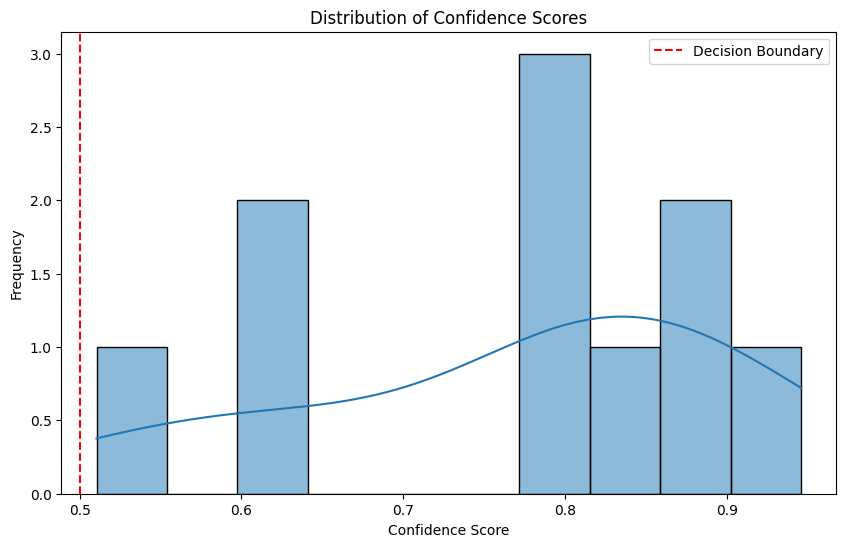

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sample_reviews['confidence_score'], bins=10, kde=True)
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()


### Prediction Distribution Pie Chart

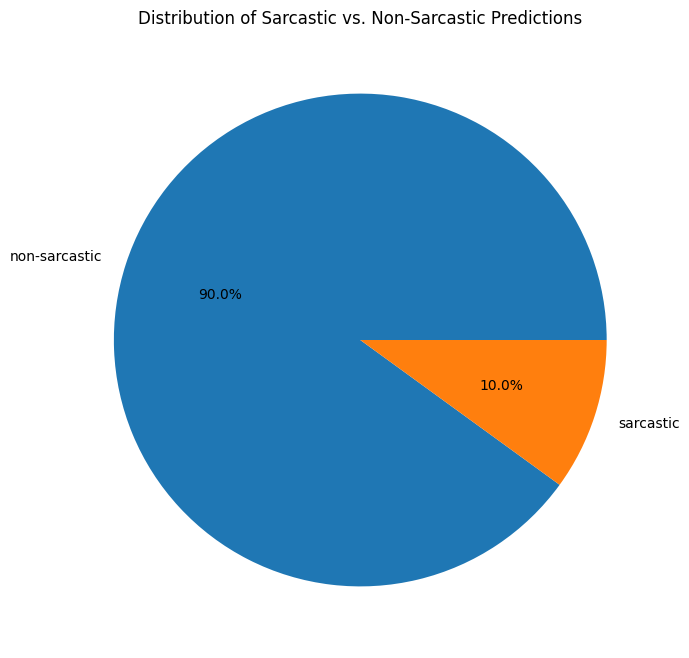

In [12]:
plt.figure(figsize=(8, 8))
prediction_counts = sample_reviews['predicted_label'].value_counts()
plt.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Sarcastic vs. Non-Sarcastic Predictions')
plt.show()


### Confidence by Prediction Type

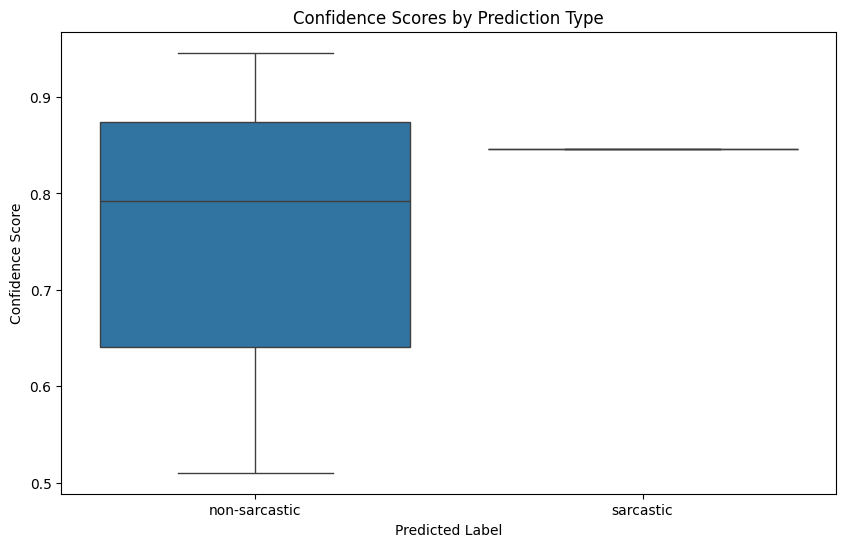

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='predicted_label', y='confidence_score', data=sample_reviews)
plt.title('Confidence Scores by Prediction Type')
plt.xlabel('Predicted Label')
plt.ylabel('Confidence Score')
plt.show()


## One Shot

In [ ]:
from transformers import pipeline

# Load the zero-shot classification pipeline
classifier = pipeline('zero-shot-classification', model='FacebookAI/roberta-large-mnli')

# Define your labels
candidate_labels = ['sarcastic', 'non-sarcastic']

# One-shot examples (one for each class)
sarcastic_example = "This game is so optimized it only crashes every 5 minutes instead of every 2! Amazing work devs!"
non_sarcastic_example = "Great gameplay mechanics and interesting story. Really enjoyed the character development."

# Function for one-shot classification
def one_shot_classify(review_text):
    # Create prompts combining examples with the review to classify
    sarcastic_prompt = f"Example of sarcastic review: {sarcastic_example}\nIs this review sarcastic too? Review: {review_text}"
    non_sarcastic_prompt = f"Example of non-sarcastic review: {non_sarcastic_example}\nIs this review non-sarcastic too? Review: {review_text}"

    # Get predictions for both prompts
    sarcastic_result = classifier(sarcastic_prompt, candidate_labels=['yes', 'no'])
    non_sarcastic_result = classifier(non_sarcastic_prompt, candidate_labels=['yes', 'no'])

    # Compare confidence scores for "yes" between the two prompts
    sarcastic_score = sarcastic_result['scores'][0] if sarcastic_result['labels'][0] == 'yes' else 1 - sarcastic_result['scores'][0]
    non_sarcastic_score = non_sarcastic_result['scores'][0] if non_sarcastic_result['labels'][0] == 'yes' else 1 - non_sarcastic_result['scores'][0]

    # Determine final prediction
    if sarcastic_score > non_sarcastic_score:
        return "sarcastic", sarcastic_score
    else:
        return "non-sarcastic", non_sarcastic_score

# Apply to your dataset
sample_reviews = steam_reviews.head(10)  # Adjust sample size as needed
predictions = []
confidence_scores = []

for review in sample_reviews['review_text']:
    label, score = one_shot_classify(review)
    predictions.append(label)
    confidence_scores.append(score)

# Add predictions to the DataFrame
sample_reviews['predicted_label'] = predictions
sample_reviews['confidence_score'] = confidence_scores

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])


Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                         review_text predicted_label  \
0                                    Ruined my life.       sarcastic   
1  This will be more of a ''my experience with th...   non-sarcastic   
2                      This game saved my virginity.       sarcastic   
3  • Do you like original games? • Do you like ga...   non-sarcastic   
4           Easy to learn, hard to master.                 sarcastic   
5             No r8 revolver, 10/10 will play again.       sarcastic   
6          Still better than Call of Duty: Ghosts...       sarcastic   
7  cant buy skins, cases, keys, stickers - gaben ...       sarcastic   
8  Counter-Strike: Ok, after 9 years of unlimited...   non-sarcastic   
9  Every server is spanish or french. I can now f...       sarcastic   

   confidence_score  
0          0.395767  
1          0.568797  
2          0.408487  
3          0.635216  
4          0.475525  
5          0.333020  
6          0.435623  
7          0.455990  
8        

<ipython-input-11-a73c62d05391>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['predicted_label'] = predictions
<ipython-input-11-a73c62d05391>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['confidence_score'] = confidence_scores


In [ ]:
sample_reviews['review_text'][7]

'cant buy skins, cases, keys, stickers - gaben cant steal our money 10/10 would play again'

# NEW

## Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

## Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Read the CSV file
dataset_path = '/content/drive/MyDrive/Masters Degree/NLP Course/Steam Reviews Sarcasm Detection Project/dataset/dataset.csv'
steam_reviews = pd.read_csv(dataset_path, nrows=60000)

# Display the first few rows
steam_reviews.head()

# Create a dataset batch for annotation
steam_reviews_annotated = steam_reviews

# Add an empty annotation column
steam_reviews_annotated['sarcasm_label'] = None

# Save to a new CSV for annotation
steam_reviews_annotated.to_csv('steam_reviews_for_annotation.csv', index=False)


Mounted at /content/drive


## Load Roberta Large mnli Model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline

# Load pre-trained model and tokenizer
model_name = "roberta-large-mnli"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Zero Shot Inference

In [ ]:
# Create classifier pipeline using explicit components
classifier = pipeline(
    "zero-shot-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

# Define labels and processing function
candidate_labels = ['sarcastic', 'non-sarcastic']
hypothesis_template = "This review is {}."

def predict_sarcasm(review_text):
    result = classifier(
        review_text,
        candidate_labels,
        hypothesis_template=hypothesis_template,
        multi_label=False
    )
    return result['labels'][0], result['scores'][0]

# Process sample reviews
sample_reviews = steam_reviews.head(10).copy()
sample_reviews[['predicted_label', 'confidence_score']] = sample_reviews['review_text'].apply(
    lambda x: pd.Series(predict_sarcasm(x))
)

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])

Device set to use cuda:0


                                         review_text predicted_label  \
0                                    Ruined my life.       sarcastic   
1  This will be more of a ''my experience with th...   non-sarcastic   
2                      This game saved my virginity.   non-sarcastic   
3  • Do you like original games? • Do you like ga...   non-sarcastic   
4           Easy to learn, hard to master.                 sarcastic   
5             No r8 revolver, 10/10 will play again.   non-sarcastic   
6          Still better than Call of Duty: Ghosts...   non-sarcastic   
7  cant buy skins, cases, keys, stickers - gaben ...   non-sarcastic   
8  Counter-Strike: Ok, after 9 years of unlimited...   non-sarcastic   
9  Every server is spanish or french. I can now f...       sarcastic   

   confidence_score  
0          0.765970  
1          0.740014  
2          0.962879  
3          0.891574  
4          0.529092  
5          0.787967  
6          0.738280  
7          0.791888  
8        

## One Shot Inference

In [ ]:
one_shot_examples = {
    "sarcastic": {
        "text": "This game is so optimized it only crashes every 5 minutes instead of every 2! Amazing work devs!",
        "label": "sarcastic"
    },
    "non-sarcastic": {
        "text": "Great gameplay mechanics and interesting story. Really enjoyed the character development.",
        "label": "non-sarcastic"
    }
}


In [ ]:
def one_shot_predict(review_text, candidate_labels):
    # Construct prompt with example and target review
    prompt_template = f"""
    Example 1 ({one_shot_examples['sarcastic']['label']}): {one_shot_examples['sarcastic']['text']}
    Example 2 ({one_shot_examples['non-sarcastic']['label']}): {one_shot_examples['non-sarcastic']['text']}
    Now classify: {review_text}
    """

    # Use the same zero-shot pipeline
    result = classifier(
        prompt_template,
        candidate_labels=candidate_labels,
        hypothesis_template="This review is {}."
    )
    return result['labels'][0], result['scores'][0]


In [ ]:
# Process sample reviews
sample_reviews = steam_reviews.head(10).copy()

# Predict using one-shot
sample_reviews[['predicted_label', 'confidence_score']] = sample_reviews['review_text'].apply(
    lambda x: pd.Series(one_shot_predict(x, candidate_labels=['sarcastic', 'non-sarcastic']))
)

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])


                                         review_text predicted_label  \
0                                    Ruined my life.       sarcastic   
1  This will be more of a ''my experience with th...       sarcastic   
2                      This game saved my virginity.   non-sarcastic   
3  • Do you like original games? • Do you like ga...       sarcastic   
4           Easy to learn, hard to master.                 sarcastic   
5             No r8 revolver, 10/10 will play again.       sarcastic   
6          Still better than Call of Duty: Ghosts...   non-sarcastic   
7  cant buy skins, cases, keys, stickers - gaben ...       sarcastic   
8  Counter-Strike: Ok, after 9 years of unlimited...       sarcastic   
9  Every server is spanish or french. I can now f...       sarcastic   

   confidence_score  
0          0.560238  
1          0.541181  
2          0.514453  
3          0.843760  
4          0.630184  
5          0.501393  
6          0.546452  
7          0.632201  
8        